# Initialization in 1850 based on synthetic experiments

We here present a new method to initialize past glacier states from climate information using the Open Global Glacier Model. The method consists of three main steps: generation of glacier states, identification of glacier candidates and their evaluation. The method is explained in detail in [Eis et al. (2019)](https://tc.copernicus.org/articles/13/3317/2019/tc-13-3317-2019.html). This notebook shows how to apply the developped method. A proper installation of OGGM and all dependencies is required to run this method. Knowledge on how to run OGGM is required!

### Set-up

In [1]:
import sys
import os
import salem

from initialization.core import *
from initialization.plots import *

from oggm import cfg, workflow,utils
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline
# settings for plots
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =15
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize']= 15 
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['figure.figsize'] = 10,10


cfg.initialize()

# path to working and plot directory
WORKING_DIR = 'workdir'
cfg.PATHS['working_dir'] = WORKING_DIR

utils.mkdir(cfg.PATHS['working_dir'], reset=False)
cfg.PATHS['plot_dir'] = os.path.join(cfg.PATHS['working_dir'], 'plots')
utils.mkdir(cfg.PATHS['plot_dir'], reset=False)

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# How many grid points around the glacier?
cfg.PARAMS['border'] = 200

# Set to True for operational runs
cfg.PARAMS['continue_on_error'] = True

# We use intersects
db = utils.get_rgi_intersects_region_file(version='61', region='11')
cfg.set_intersects_db(db)

cfg.PARAMS['run_mb_calibration'] = True
cfg.PARAMS['optimize_inversion_params'] = False

/mnt/c/Users/Julia/Documents/Python Scripts/initialization/initialization/plots.py:10: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
2020-09-04 10:57:18: oggm.cfg: Using configuration file: /home/julia/oggm/oggm/params.cfg


### Glacier outlines and climate data
The glacier outlines are obtained from the Randolph Glacier Inventory. We here use a subset of the region 11 only (Oetztal Alps). As climate data we use the HISTALP dataset.  

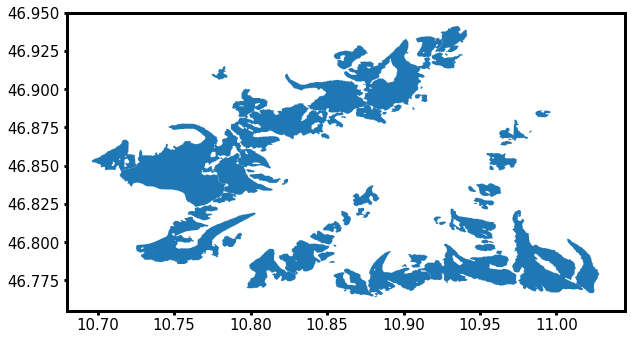

In [2]:
# read shapefile with 66 glaciers in the Oetztal Alps
rgidf = salem.read_shapefile('../rgi/oetztal.shp')

# sort for efficient using
rgidf = rgidf.sort_values('Area', ascending=False)
rgidf.plot()

# Use HISTALP climate file
cfg.PARAMS['baseline_climate'] = 'HISTALP'

### Preprocessing of OGGM
The function "preprocessing(gdirs)" runs all required steps of OGGM, before we can start to reconstruct the glacier. This includes e.g. the calculation of the flowlines, the processing of the HISTALP dataset, and the inversion. Cause to large computational costs, we will focus from now on one glacier (a small one, becasue the calculation is quicker then), only.

In [3]:
# initization of OGGM
gdirs = workflow.init_glacier_regions(rgidf)
gdir = workflow.init_glacier_regions(rgidf[rgidf.RGIId=='RGI60-11.00779'])[0]

# this function only needs to be run ONE time
#preprocessing(gdirs)

gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00779
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.375 km2
  Lon, Lat: (10.8009, 46.8542)
  Grid (nx, ny): (464, 456)
  Grid (dx, dy): (26.0, -26.0)

### Synthetic experiments
We use synthetic experiments to test the performance of our method. As the method is still under developpment, we recommend to use the method only in combination with the synthetic experiments. Otherwise it is not guaranteed, that the glacier candidates converge towards the observation and wrong reconstructions could result. A further development of the method allowing the reconstruction of real-world cases is already under developement and will follow soon. 

In [11]:
# creates the experiments for a list of glacier in parallel
synthetic_experiments_parallel([gdir], 1850,2000)


Running the function synthetic_experiments will reset the previous results. Are you  sure you like to continue? [Y/n] 

 n


A glacier for the year 1850 is created by running a random climate task with the temperature bias -1 for 600 years. This glacier will be run forward from 1850 to 2000. The resulting glacier is from now on the observed glacier. 

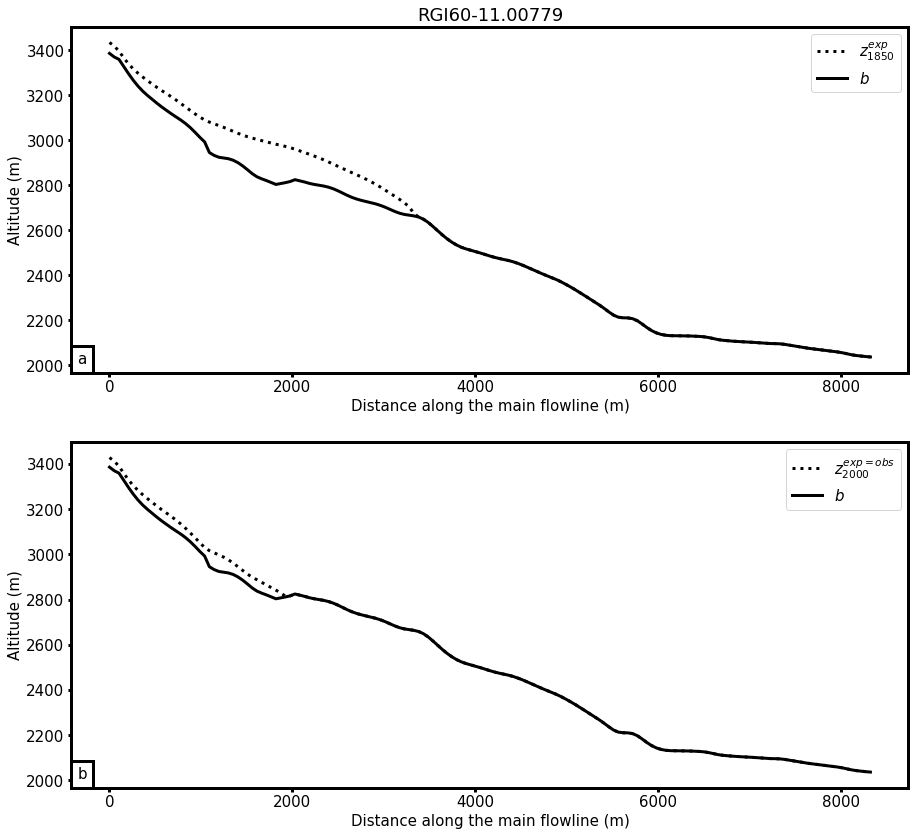

In [5]:
# reads the expermient model
ep = gdir.get_filepath('model_run', filesuffix='_synthetic_experiment')
ex_mod = FileModel(ep)

# plots cross section along the flowline in 1850 and 2000
plot_experiment(gdir,ex_mod,1850,2000,cfg.PATHS['plot_dir'])

Subfigure a) shows the synthetic experiment glacier in 1850 and subfigure b) the synthetic experiment glacier in 2000. 

### Reconstruction of the state in 1850
We now try to reconstruct the synthetic experiment glacier in 1850 by only using information about the past climate and the geometry of the synthetic experiment glacier in 2000. To this end, you need to call the function `find_possible_glaciers(gdir,y0,ye,n)`, with the GlacierDirectory `gdir`, the year of the searched state `y0`, the year of the observation `ye` and `n` the number of glacier candidates to test. We choose `n=200` and reconstruct this glacier in `y0=1850`. This computation can take a while (...)


In [6]:
results = find_possible_glaciers(gdir, 1850, 2000, 200)
results['volume'] = results.model.apply(lambda x: x.volume_km3)
results

,fitness,fitness_fls,model,temp_bias,time,volume
0,0.031982,0.762368,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,223,0.547967
1,0.033290,0.757787,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,306,0.582190
2,0.034867,0.752441,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,319,0.609850
3,0.034846,0.752522,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,320,0.619477
4,0.033958,0.755497,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,328,0.613198
...,...,...,...,...,...,...
195,0.020401,0.809187,<oggm.core.flowline.FileModel object at 0x7fea...,-1.55,470,0.227634
196,0.022965,0.797602,<oggm.core.flowline.FileModel object at 0x7fea...,-1.55,513,0.243166
197,0.028194,0.776292,<oggm.core.flowline.FileModel object at 0x7fea...,-1.45,202,0.289811
198,0.025899,0.785318,<oggm.core.flowline.FileModel object at 0x7fea...,-1.45,309,0.277369


The output is a `panda.DataFrame()` with following informations for each tested glacier candidate:
- OGGM's FileModel of the past climate run from y0 to ye, 
- the objective (also called fitness value), and 
- the temperature bias and time point from the random climate runs to identify later which candidate was picked.

From the FileModel all required inforamtions (e.g. volume, area, length, surface elevations at grid points) can be obtained. All previous model_runs will be saved and stored in a new directory named by the initialization year. If the function should be run a second time for the same glacier (e.g. with more candidates), the algorithm first checks, if this model_run was already done and reads the corresponding FileModel, if this is the case. Hereby it is avoided that the same runs will be run twice. Let's try this out and run the same function again ...

In [7]:
results = find_possible_glaciers(gdir, 1850, 2000, 200)
results

,fitness,fitness_fls,model,temp_bias,time,volume
0,0.031982,0.762368,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,223,0.547967
1,0.033290,0.757787,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,306,0.582190
2,0.034867,0.752441,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,319,0.609850
3,0.034846,0.752522,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,320,0.619477
4,0.033958,0.755497,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,328,0.613198
...,...,...,...,...,...,...
195,0.020401,0.809187,<oggm.core.flowline.FileModel object at 0x7fea...,-1.55,470,0.227634
196,0.022965,0.797602,<oggm.core.flowline.FileModel object at 0x7fea...,-1.55,513,0.243166
197,0.028194,0.776292,<oggm.core.flowline.FileModel object at 0x7fea...,-1.45,202,0.289811
198,0.025899,0.785318,<oggm.core.flowline.FileModel object at 0x7fea...,-1.45,309,0.277369


### Graphics
#### Glacier candidates
The function `plot_candidates` plots the random climate tasks and the identified glacier candidates, colored by their Fitness value. 

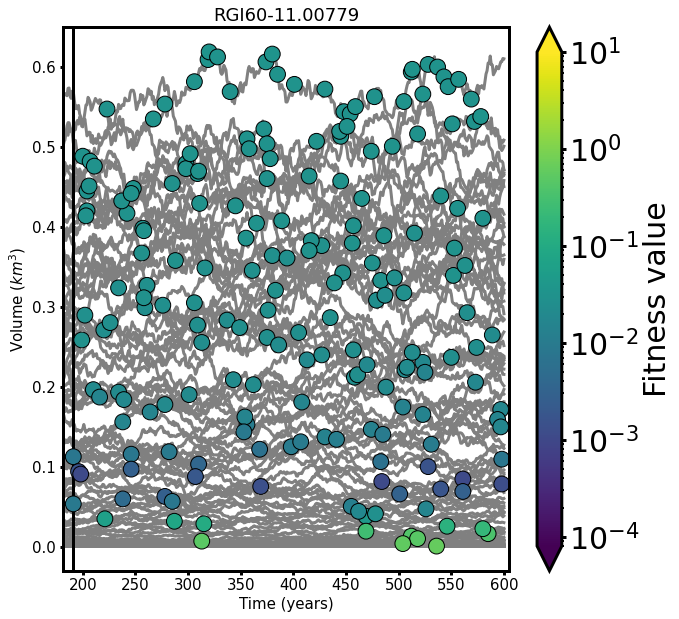

In [8]:
plot_candidates(gdir, results, 1850, 'step3',cfg.PATHS['plot_dir'])

#### Cross-Section colored by Fitness value
The function `plot_surface` plot the cross-Section along the main flowline of all glacier candidates at 1850 and 2000, as well as the volumes between 1850-2000. 

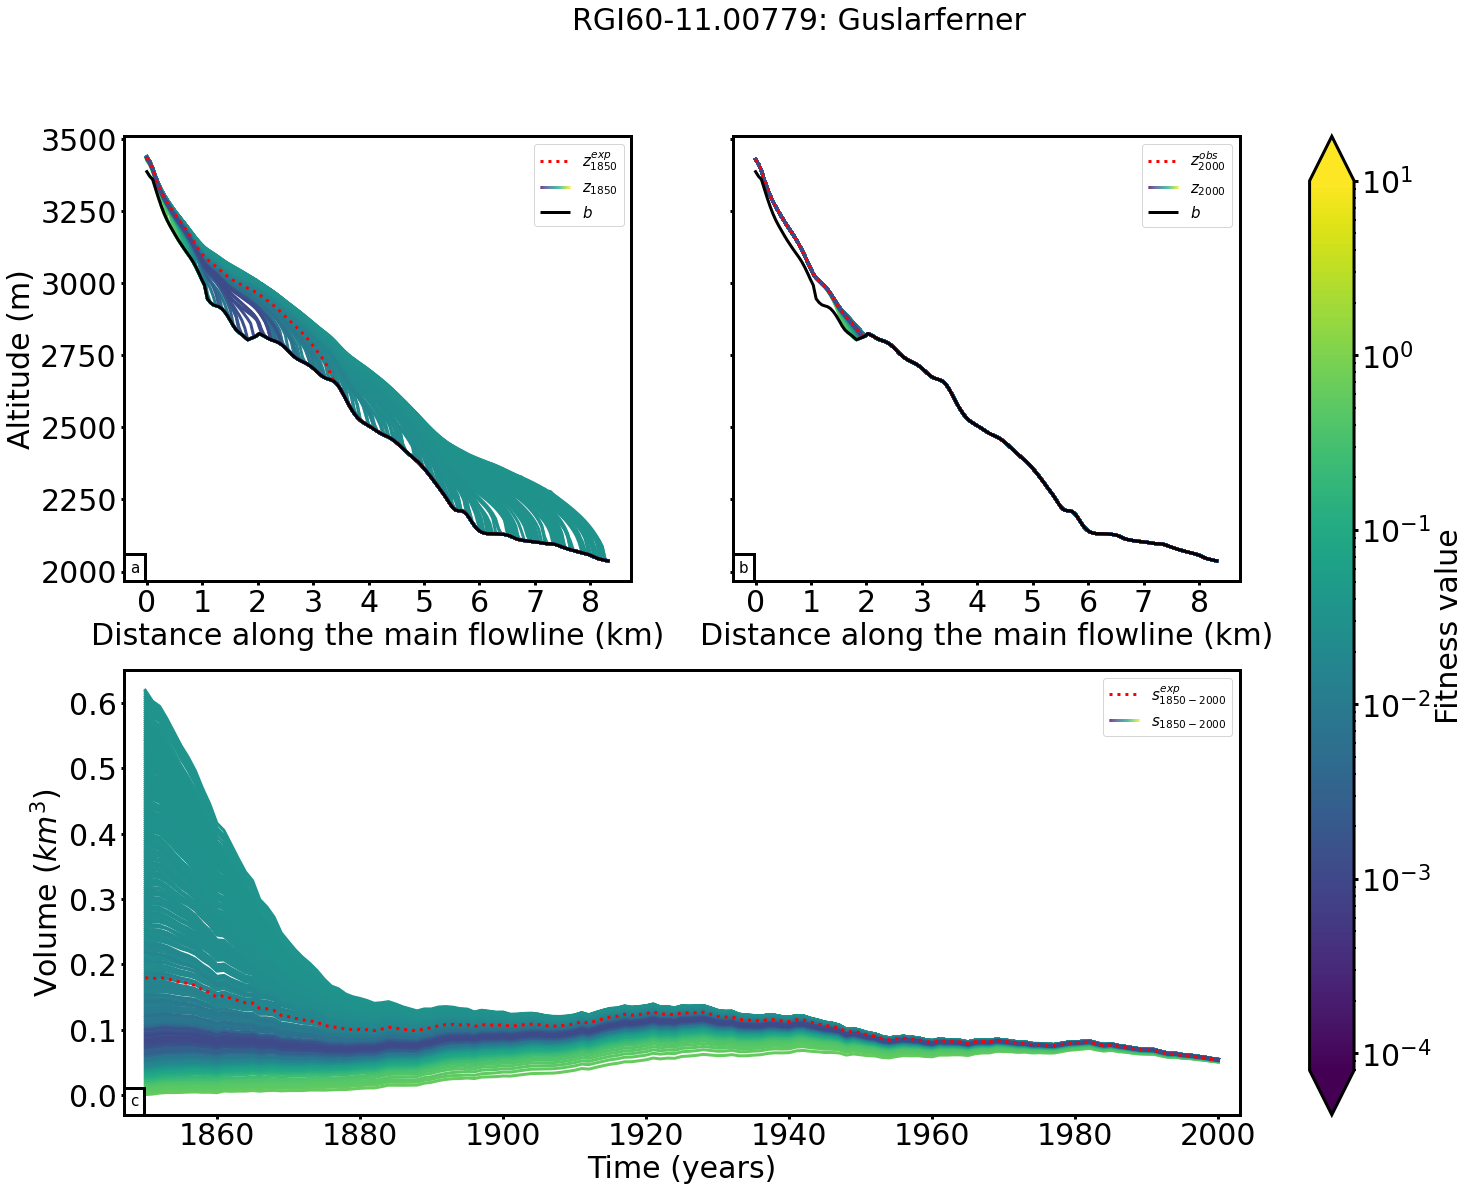

In [9]:
plot_fitness_values(gdir,results, ex_mod,1850,cfg.PATHS['plot_dir'])

We suggest to accept all candidates with a fitness value smaller than 1 (which are in this case all). 

In [10]:
results[results['fitness']<= 1]

,fitness,fitness_fls,model,temp_bias,time,volume,Fitness value
0,0.031982,0.762368,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,223,0.547967,0.031982
1,0.033290,0.757787,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,306,0.582190,0.033290
2,0.034867,0.752441,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,319,0.609850,0.034867
3,0.034846,0.752522,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,320,0.619477,0.034846
4,0.033958,0.755497,<oggm.core.flowline.FileModel object at 0x7fea...,-3.00,328,0.613198,0.033958
...,...,...,...,...,...,...,...
195,0.020401,0.809187,<oggm.core.flowline.FileModel object at 0x7fea...,-1.55,470,0.227634,0.020401
196,0.022965,0.797602,<oggm.core.flowline.FileModel object at 0x7fea...,-1.55,513,0.243166,0.022965
197,0.028194,0.776292,<oggm.core.flowline.FileModel object at 0x7fea...,-1.45,202,0.289811,0.028194
198,0.025899,0.785318,<oggm.core.flowline.FileModel object at 0x7fea...,-1.45,309,0.277369,0.025899


#### Median state 
We also found out that the median state of the 5% quantile of all glaciers with a fitness value smaller than 1 fits well with the experient. To create a plot, showing the interquantile range and the median state you can use the function `plot_median`:

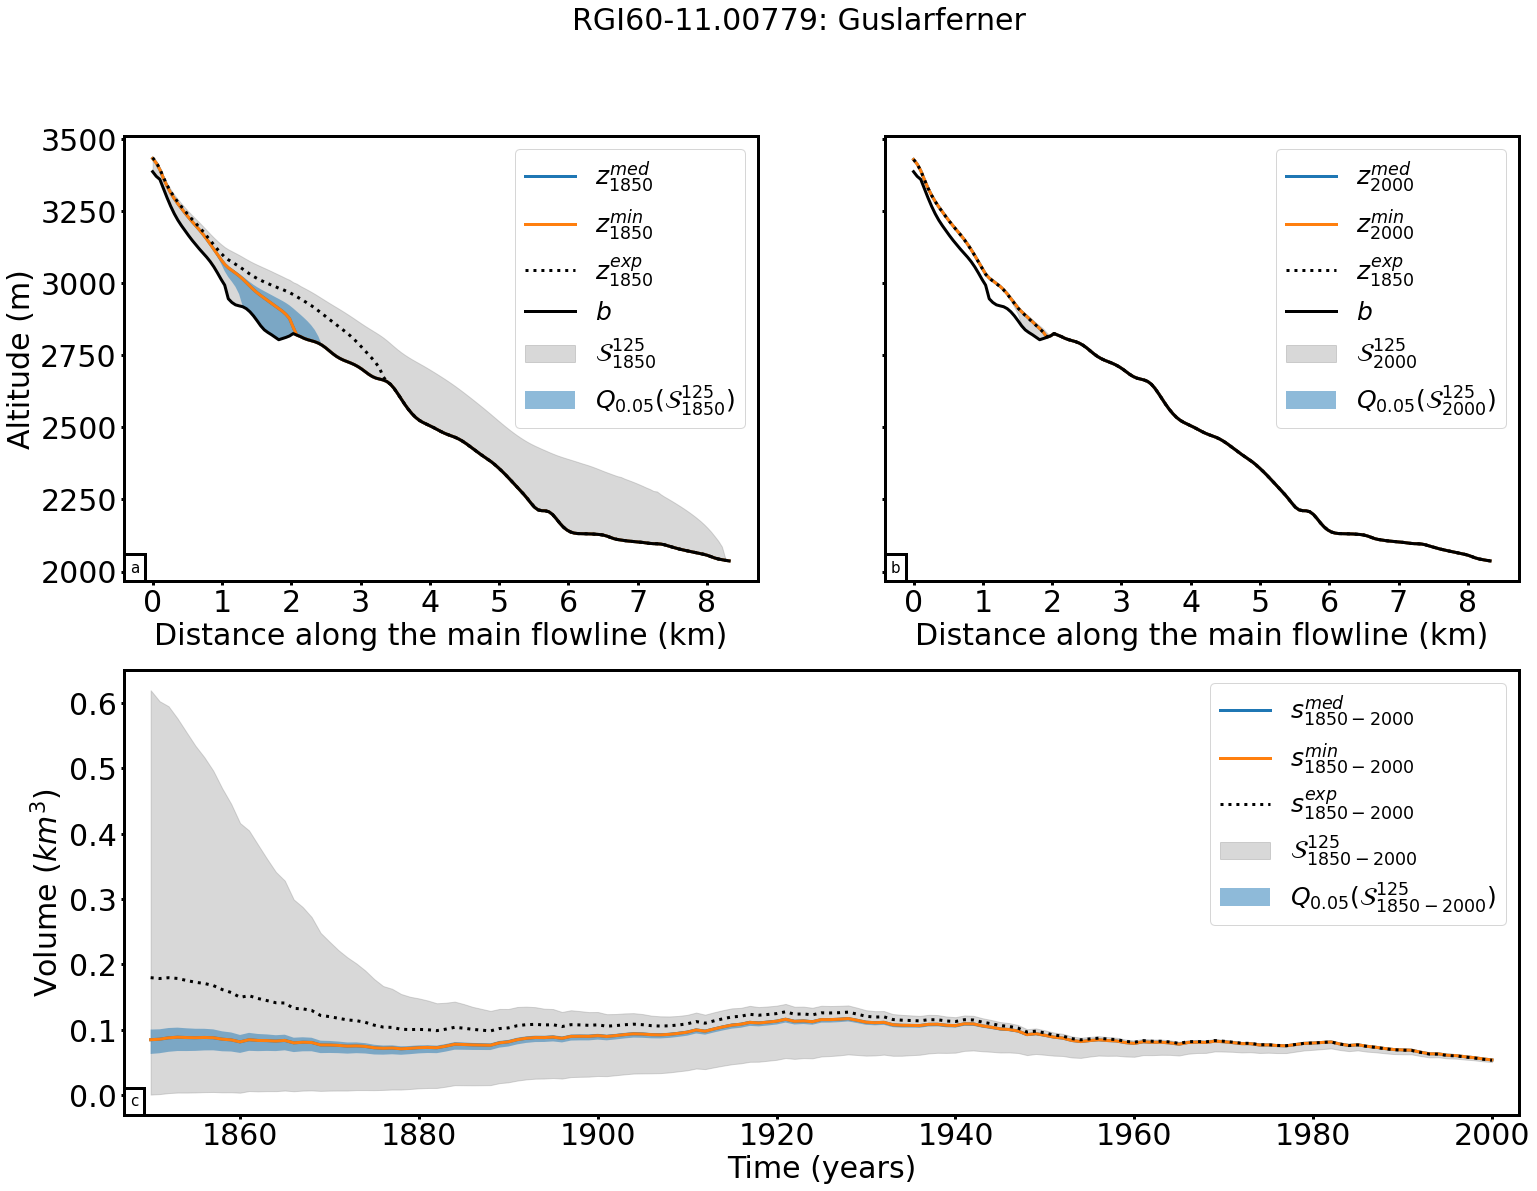

In [12]:
med_mod = plot_median(gdir,results,125,ex_mod,1850,2000, cfg.PATHS['plot_dir'])

The grey area, shows all glacier states with a fitness value smaller than 1. The blue area is the 5% quantile and the blue line represents the median state (here: identically with the orange line (minimum fitness value)). Additionally this function returns the FileModel of the median state to be able to use it for other runs. This is the best estimate of the reconstructed state in 1850. 

The uncertainties of the method are reduced, when running this state forward in time: 

In [13]:
print('error to experiment in 1850:', str(med_mod.volume_km3_ts()[1850]-ex_mod.volume_km3_ts()[1850]))

print('error to experiment in 1900', str(med_mod.volume_km3_ts()[1900]-ex_mod.volume_km3_ts()[1900]))

print('error to experiment in 1950', str(med_mod.volume_km3_ts()[1950]-ex_mod.volume_km3_ts()[1950]))

error to experiment in 1850: -0.09498425025379227
error to experiment in 1900 -0.01654067198703363
error to experiment in 1950 -0.003559309846876066
